In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb

plt.rcParams.update({"figure.figsize": (12, 8), "font.size": 14})

In [2]:
# random number generator with a fixed seed
rng = np.random.default_rng(12345)

### Get power spectrum

In [3]:
# cosmological parameters used to generate the power spectrum
cparams = camb.CAMBparams(ombh2=0.05 * 0.67**2, omch2=0.25 * 0.67**2, H0=67.)

# interpolation function for the matter power spectrum
pk = camb.get_matter_power_interpolator(cparams, nonlinear=False, zmax=1000)

In [4]:
# Define a k axis to make some plots
# CAMB uses units of Mpc/h
kh = np.logspace(-4, 1, 1000)

Text(0, 0.5, '$P(k)$ $(Mpc/h)^3$')

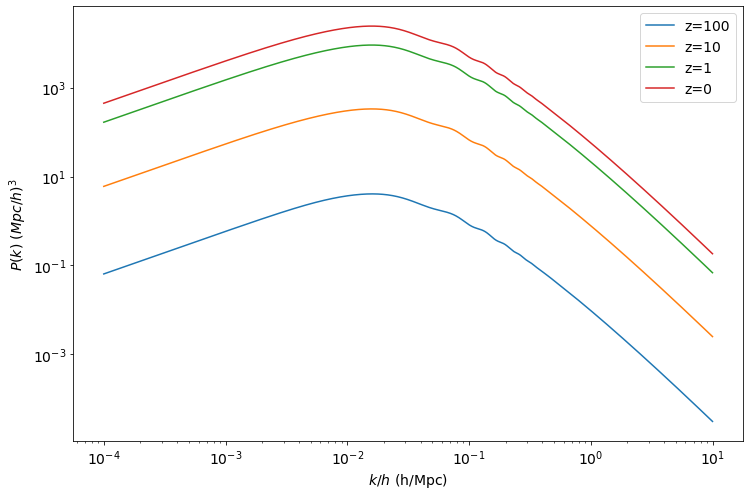

In [5]:
# Plot the power spectrum at a few redshifts
for z in [100, 10, 1, 0]:
    plt.plot(kh, pk.P(z, kh), label=f"z={z}")
plt.legend()
plt.loglog()
plt.xlabel("$k/h$ (h/Mpc)")
plt.ylabel("$P(k)$ $(Mpc/h)^3$")

### Draw a realisation of density contrast
We will draw random gaussian fluctuations from the power spectrum.

In [6]:
# Define a discrete grid and spacing in Mpc/h
# We use a box with two long sides (N) and one short side (M) to save some memory
N = 512
M = 16
d = 2  # Mpc / h spacing

# Draw a Gaussian white noise realisation in real-space, the short axis is the last one.
# We will transform this into k-space, apply the power spectrum and transform back. The 
# rationale for starting in real-space is that we don't need to figure the internal
# normalisation of the FFT routines, just assume that the forward and reverse transforms
# are inverses.
white_noise = np.random.standard_normal((N, N, M))

# As we're dealing with a real-valued field, we will use a real-to-complex FFT.
# This returns one axis with only the positive wavenumbers (as the negative frequencies
# are the complex conjugates). By convention this is the last axis, which is also the
# short axis.
# Use the numpy `fftfreq` routines to get the wavenumbers for each position on the 
# long (x, y) or short (z) axes. The factor of 2 pi is because in cosmology we an angular
# frequency convention (i.e. the phase factor in the FT is e^{i k x}), whereas FFT
# routines typically use a regular frequency convention (i.e. e^{2 pi i f t}).
klong = 2 * np.pi * np.fft.fftfreq(N, d=d)
kshort = 2 * np.pi * np.fft.rfftfreq(M, d=d)

# Construct arrays for the wavenumbers along the x, y, z axes
kx = klong[:, np.newaxis, np.newaxis]
ky = klong[np.newaxis, :, np.newaxis]
kz = kshort[np.newaxis, np.newaxis, :]

# The total wavenumber for each element in k-space
k_grid = np.sqrt(kx**2 + ky**2 + kz**2)

# Initial redshift
z0 = 1000.0

# Get the power spectrum amplitude for each cell. Mapping the continuous power spectrum
# into a discrete version (easiest calculation computes the variance in each case and 
# finds the normalisation) generates a 1 / V_cell factor, where V_cell is the size of a
# grid cell, i.e. d^3
P_discrete = pk.P(z0, k_grid) / (d**3)

# Scale the white noise realisation in k-space, remove the constant mode (which may be ill defined), and transform back
delta_k = np.fft.rfftn(white_noise) * P_discrete**0.5
delta_k[0, 0, 0] = 0.0
delta = np.fft.irfftn(delta_k)

/Users/richard/Projects/CHIME/eboss_stacking/venv/lib/python3.9/site-packages/camb/results.py:960: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))


<ipython-input-7-58008e1b3553>:5: RuntimeWarning: divide by zero encountered in log10
  im = ax[1].imshow(np.log10(np.fft.fftshift(np.abs(delta_k[..., 0])**2)), origin="lower")


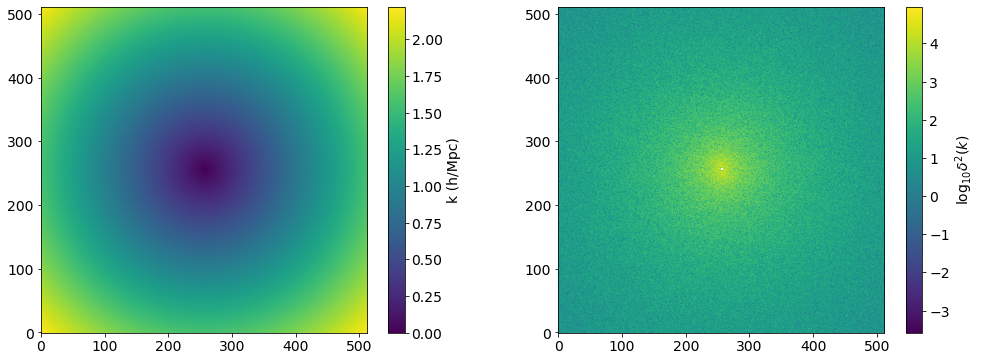

In [7]:
# quick plot of k and delta^2(k)
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
im = ax[0].imshow(np.fft.fftshift(k_grid[..., 0]), origin="lower")
plt.colorbar(im, ax=ax[0], label="k (h/Mpc)")
im = ax[1].imshow(np.log10(np.fft.fftshift(np.abs(delta_k[..., 0])**2)), origin="lower")
plt.colorbar(im, ax=ax[1], label="$\log_{10}\delta^2(k)$")

Text(0.5, 1.0, 'z = 0 Mpc/h')

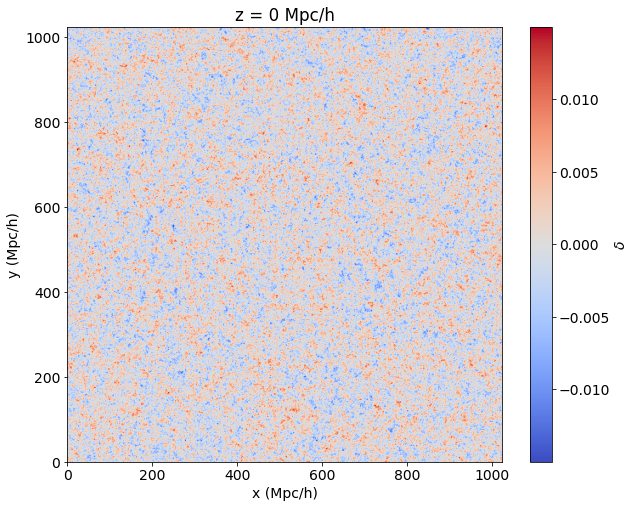

In [8]:
# Plot the density contrast field at Z=0
vlim = 4 * delta.std()
fig, axis = plt.subplots(1, 1, figsize=(10, 8))

im = axis.imshow(delta[..., 0], cmap="coolwarm", origin="lower", extent=(0, N * d, 0, N * d), vmin=-vlim, vmax=vlim)
fig.colorbar(im, label="$\delta$")
axis.set_xlabel("x (Mpc/h)")
axis.set_ylabel("y (Mpc/h)")
axis.set_title("z = 0 Mpc/h")

# zoom in if desired
#axis.set_xlim(-100, 100)
#axis.set_ylim(-100, 100)